In [1]:
from load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import torch

In [2]:
dataset = Dataset4h5('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5', num_image=48, num_redshift=64, HII_DIM=64, rescale=False, dim=3)

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 48 images randomly
images loaded: (48, 1, 64, 64, 64)
params loaded: (48, 2)
images rescaled to [0.0, 83.05072784423828]
params rescaled to [4.038963929357938, 249.60561035357284]


In [3]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5") as f:
    print(f.keys())
    print(f['redshifts_distances'])
    los = f['redshifts_distances'][:,-dataset.num_redshift:]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "redshifts_distances": shape (2, 514), type "<f8">


In [4]:
los.shape

(2, 64)

In [5]:
dataloader = DataLoader(dataset, batch_size=48)

In [6]:
len(dataloader)

1

In [7]:
x, c = next(iter(dataloader))

In [8]:
x.shape

torch.Size([48, 1, 64, 64, 64])

In [9]:
c.shape

torch.Size([48, 2])

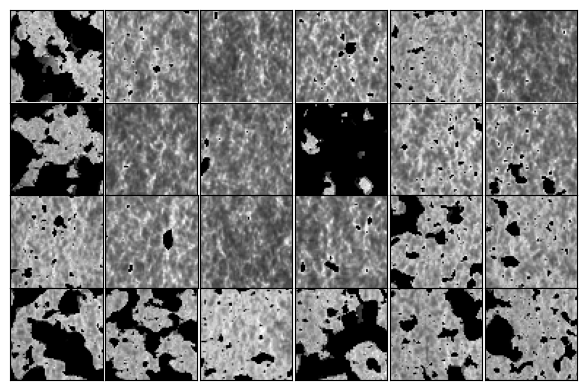

In [10]:
# for i in range(len(x)):
#     plt.imshow(x[i,0,:,0,:])
#     plt.show()
# row = 4
# col = 6
# samples = x[:,:,:,0,:]
def plot(samples, row=4, col=6):
    plt.figure(figsize = (6,4))
    for i in range(24):
        plt.subplot(row,col,i+1)
        plt.imshow(samples[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
        plt.xticks([])
        plt.yticks([])
        # plt.show()
    # plt.suptitle('simulations')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    plt.show()
    
plot(x[:,:,:,0,:])

In [11]:
print(x.shape)
Tb = torch.mean(x, axis=2)
print(Tb.shape)
Tb = torch.mean(Tb, axis=2)
print(Tb.shape)
# print(Tb.shape)
# print(Tb[:,0,:].shape)
# print(Tb[:10, 0, :].shape)

torch.Size([48, 1, 64, 64, 64])
torch.Size([48, 1, 64, 64])
torch.Size([48, 1, 64])


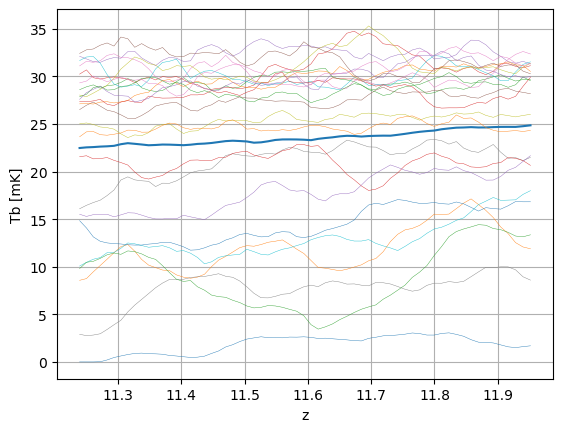

In [12]:
plt.plot(los[0,:], Tb[:,0,:].mean(axis=0))
for i in range(24):
    plt.plot(los[0,:], Tb[i,0,:], lw=0.3)
# plt.plot(los[0,:], Tb[1,0,:])
# plt.plot(los[0,:], Tb[2,0,:])
# plt.yscale('log')
plt.grid()
plt.ylabel('Tb [mK]')
plt.xlabel('z')
plt.show()

In [13]:
x.shape

torch.Size([48, 1, 64, 64, 64])

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def compute_power_spectrum(density_field, box_size):
    """
    计算三维密度场的物质功率谱
    
    参数:
    density_field (numpy.ndarray): 三维密度场数组
    box_size (tuple): 盒子的物理大小 (Lx, Ly, Lz) 单位为Mpc/h

    返回:
    k_vals (numpy.ndarray): 波数
    Pk (numpy.ndarray): 功率谱
    """
    # print("density_field.dim =", density_field.dim())
    if density_field.dim() == 3:
        Nx, Ny, Nz = density_field.shape
        Lx, Ly, Lz = box_size
    elif density_field.dim() == 2:
        Nx, Ny = density_field.shape
        Lx, Ly = box_size
    else:
        raise ValueError(f"density_field.dim must be 2 or 3, instead of {density_field.dim()}")
    # print("Nx, Ny, Nz =", Nx, Ny, Nz)
    # 计算傅里叶变换
    delta_k = np.fft.fftn(density_field)
    delta_k = np.fft.fftshift(delta_k)  # 将零频移到中心

    # 计算功率谱
    if density_field.dim() == 3:
        Pk = np.abs(delta_k) ** 2 / (Nx * Ny * Nz)
    elif density_field.dim() ==2:
        Pk = np.abs(delta_k) ** 2 / (Nx * Ny)
    # print("Pk.shape =", Pk.shape)
    # 创建波数k的网格
    kx = np.fft.fftfreq(Nx, d=Lx / Nx)
    ky = np.fft.fftfreq(Ny, d=Ly / Ny)

    if density_field.dim() == 3:
        kz = np.fft.fftfreq(Nz, d=Lz / Nz)
        kx, ky, kz = np.meshgrid(kx, ky, kz, indexing='ij')
        k = np.sqrt((kx**2) + (ky**2) + (kz**2))
    elif density_field.dim() == 2:
        kx, ky = np.meshgrid(kx, ky, indexing='ij')
        k = np.sqrt((kx**2) + (ky**2))
    # print("k.shape =", k.shape)
    # 将结果移回零频在中心
    k = np.fft.fftshift(k)
    Pk = np.fft.fftshift(Pk)

    # 排除零波数，避免对数变换出错
    k = k.flatten()
    Pk = Pk.flatten()
    # print("np.min(k) =", np.min(k))
    mask = k > 0
    k = k[mask]
    Pk = Pk[mask]

    # 创建波数的对数间隔
    k_bins = np.logspace(np.log10(k.min()), np.log10(k.max()), num=20)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    Pk_vals = np.zeros_like(k_vals)

    # 在每个波数区间内进行平均
    for i in range(len(k_bins) - 1):
        bin_mask = (k >= k_bins[i]) & (k < k_bins[i+1])
        if np.any(bin_mask):
            Pk_vals[i] = np.mean(Pk[bin_mask])

    return k_vals, Pk_vals


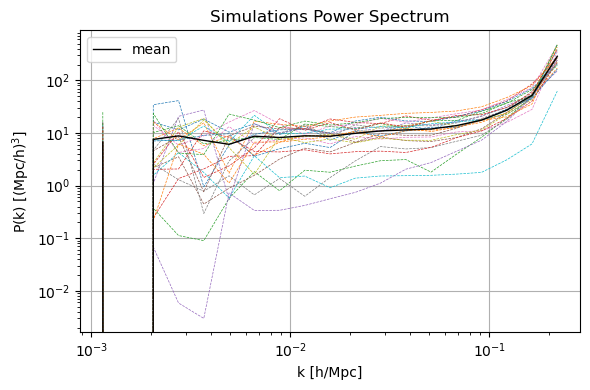

In [15]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
plt.figure(figsize=(6, 4), dpi=100)
k_vals_all = []
Pk_vals_all = []
for i in range(24):
    density_field = x[i,0,:,0,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
    if density_field.dim() == 3:
        Nx, Ny, Nz = density_field.shape
        box_size = (128.0, 128.0, 1024.0)
    elif density_field.dim() == 2:
        Nx, Ny = density_field.shape
        box_size = (128.0, 1024.0)

    # 计算物质功率谱
    k_vals, Pk_vals = compute_power_spectrum(density_field, box_size)
    k_vals_all.append(k_vals)
    Pk_vals_all.append(Pk_vals)

    # 计算Delta^2(k)
    # Delta2_vals = k_vals**3 * Pk_vals / (2 * np.pi**2)

    # 计算 k^2 P(k) / (4 * pi^2)
    # k2Pk_vals = k_vals**2 * Pk_vals / (4 * np.pi**2)

    # 绘制功率谱
    # plt.subplot(1, 1, 1)
    plt.loglog(k_vals, Pk_vals, '--', lw=0.5)#, 'b-')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P(k) [(Mpc/h)$^3$]')
plt.title('Simulations Power Spectrum')
plt.grid(True)

k_vals_all = np.array(k_vals_all)
# print(k_vals_all.shape)
Pk_vals_all = np.array(Pk_vals_all)
# print(Pk_vals_all.shape)
    # plt.subplot(2, 1, 2)
    # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
    # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
    # plt.xlabel('k [h/Mpc]')
    # plt.ylabel('Power')
    # plt.title('Normalized Power Spectrum')
    # # plt.legend()
    # plt.grid(True)

plt.loglog(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'k-', lw=1, label='mean')
k_vals_all_sim = k_vals_all
Pk_vals_all_sim = Pk_vals_all
plt.tight_layout()
plt.legend()
plt.show()

In [23]:
ll -lth outputs

total 860M
-rw-r--r--  1 bxia34 385K May 28 23:38 0528-2336.npy
-rw-r--r--  1 bxia34 848M May 28 23:36 model_state.pth
drwxr-xr-x 18 bxia34 4.0K May 28 23:19 logs/
-rw-r--r--  1 bxia34 385K May 28 23:03 0528-2301.npy
-rw-r--r--  1 bxia34 385K May 28 17:34 0528-1732.npy
-rw-r--r--  1 bxia34 385K May 28 16:26 0528-1624.npy
-rw-r--r--  1 bxia34 385K May 28 14:35 0528-1433.npy
-rw-r--r--  1 bxia34 385K May 28 14:17 0528-1416.npy
-rw-r--r--  1 bxia34 385K May 27 21:55 0527-2152.npy
-rw-r--r--  1 bxia34 3.1M May 27 21:34 0527-2117.npy
-rw-r--r--  1 bxia34 3.1M May 27 20:08 0527-1951.npy
-rw-r--r--  1 bxia34 3.1M May 27 14:36 0527-1419.npy


In [24]:
# x_sample = np.load("outputs/0527-1951.npy")
x_sample = np.load("outputs/0528-2336.npy")
print(x_sample.shape)
x_sample = torch.from_numpy(x_sample)
print(x_sample.shape)

(24, 1, 64, 64)
torch.Size([24, 1, 64, 64])


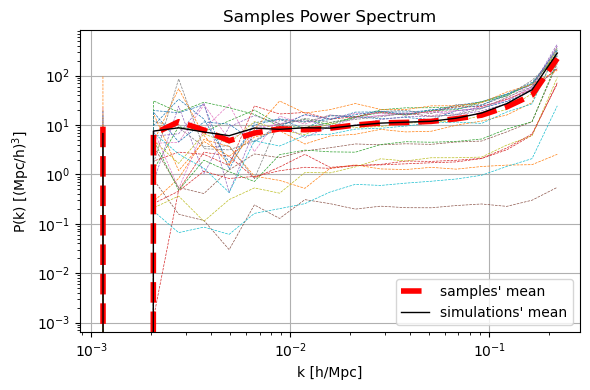

In [25]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
plt.figure(figsize=(6, 4), dpi=100)
k_vals_all = []
Pk_vals_all = []
for i in range(24):
    
    density_field = (x_sample[i,0,:,:]+1)/2 * 80#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
    if density_field.dim() == 3:
        Nx, Ny, Nz = density_field.shape
        box_size = (128.0, 128.0, 1024.0)
    elif density_field.dim() == 2:
        Nx, Ny = density_field.shape
        box_size = (128.0, 1024.0)

    # 计算物质功率谱
    k_vals, Pk_vals = compute_power_spectrum(density_field, box_size)
    k_vals_all.append(k_vals)
    Pk_vals_all.append(Pk_vals)

    # 计算Delta^2(k)
    # Delta2_vals = k_vals**3 * Pk_vals / (2 * np.pi**2)

    # 计算 k^2 P(k) / (4 * pi^2)
    # k2Pk_vals = k_vals**2 * Pk_vals / (4 * np.pi**2)

    # 绘制功率谱
    # plt.subplot(1, 1, 1)
    plt.loglog(k_vals, Pk_vals, '--', lw=0.5)#, 'b-')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P(k) [(Mpc/h)$^3$]')
plt.title('Samples Power Spectrum')
plt.grid(True)

k_vals_all = np.array(k_vals_all)
# print(k_vals_all.shape)
Pk_vals_all = np.array(Pk_vals_all)
# print(Pk_vals_all.shape)
    # plt.subplot(2, 1, 2)
    # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
    # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
    # plt.xlabel('k [h/Mpc]')
    # plt.ylabel('Power')
    # plt.title('Normalized Power Spectrum')
    # # plt.legend()
    # plt.grid(True)

plt.loglog(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
plt.loglog(k_vals_all_sim.mean(axis=0), Pk_vals_all_sim.mean(axis=0), 'k-', lw=1, label="simulations' mean")

plt.legend()
plt.tight_layout()
plt.show()

torch.Size([24, 1, 64, 64])


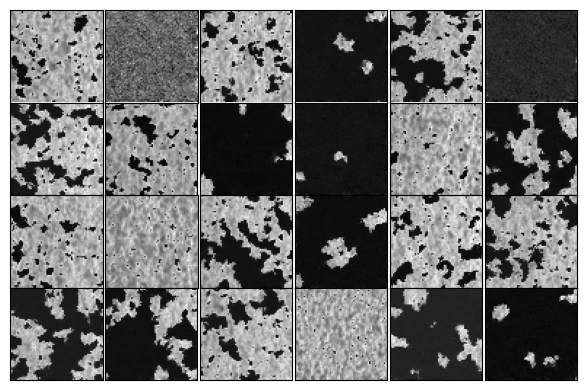

In [26]:
# for i in range(24):
#     plt.imshow(x_sample[i,0])
#     plt.show()
print(x_sample.shape)
plot(x_sample)

torch.Size([24, 1, 64, 64])
x_sample tensor(0.7083) tensor(-1.4342)
x_sample tensor(0.7083) tensor(-1.)
Tb tensor(37.0239) tensor(0.)


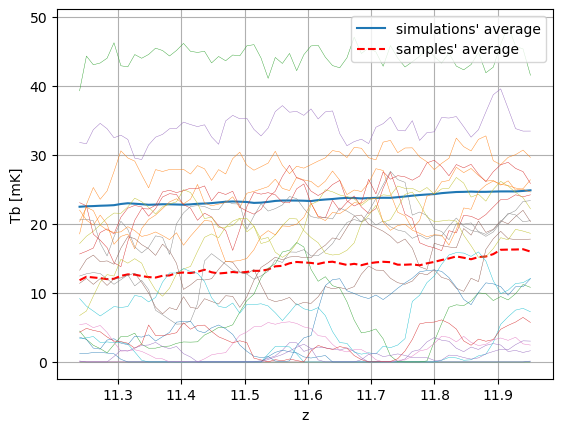

In [27]:
print(x_sample.shape)
print("x_sample", x_sample.max(), x_sample.min())
x_sample_truc = torch.where(x_sample < -1, -1, x_sample)
print("x_sample", x_sample_truc.max(), x_sample_truc.min())
Tb_sample = (x_sample_truc.mean(axis=2) + 1) / 2 *80
print("Tb", Tb.max(), Tb.min())
plt.plot(los[0,:], Tb[:,0,:].mean(axis=0), label="simulations' average")
plt.plot(los[0,:], Tb_sample[:,0,:].mean(axis=0), 'r--', label="samples' average")
for i in range(24):
    plt.plot(los[0,:], Tb_sample[i,0,:], lw=0.3)
# plt.plot(los[0,:], Tb[1,0,:])
# plt.plot(los[0,:], Tb[2,0,:])
# plt.yscale('log')
plt.ylabel('Tb [mK]')
plt.xlabel('z')
plt.grid()
plt.legend()
plt.show()